# VR Subreddit NLP Project

By: Jen Zieger

## Executive Summary

#### Problem Statement
Reddit is planning to deploy an improved model for predicting what video game-related subreddit a submission comes from. I've been contracted by Reddit to work on this project with a focus on virtual reality and build a model that accurately predicts whether a submission came from the subreddit [`r/PSVR`](https://www.reddit.com/r/PSVR/) or [`r/oculus`](https://www.reddit.com/r/oculus/). 

#### Overview
According to Merriam-Webster Dictionary, virtual reality, also known as VR, is an artificial environment which is experienced through sensory stimuli (such as sights and sounds) provided by a computer and in which one's actions partially determine what happens in the environment [[1]](https://www.merriam-webster.com/dictionary/virtual%20reality). Reddit is a network of millions of people who are connected through thousands of communities where they can connect by sharing their interests, hobbies, and passions [[2]](https://www.redditinc.com/).

#### Strategy

**Data Collection** <br>
Using [Pushshift's](https://github.com/pushshift/api) API, I will collect over 1500 submissions from the /r/PSVR and /r/oculus subreddits, totaling 3000+ submissions. The submissions collected will be from the dates May 19th, 2021 to Oct 4th, 2021.
<br>
<br>
To view my data collection process, please go to [VR subreddit sata collection]('./VR-subreddit-data-collection.ipynb')

**Data Cleaning and EDA** <br>
Through data cleaning methods, I will ensure there are no duplicate submissions and that there are unique post ids for each document. I will also check datatypes, outliers, dropping unnecessary rows/columns, and use feature engineering if needed.
<br>
<br>
My exploratory data analysis will include:
- Distribution Plots
- Correlation Matrix
- Summary Statistics
- Additional Analysis as Needed

**Pre-Processing and Modeling** <br>
I will be developing the following models: 
- Baseline 
- Multinomial Naive Bayes
- Random Forest
- Support Vector Machine
- Logistic Regression

The following methods will be used to develop these models: 
- Term Frequency — Inverse Document Frequency (TF-IDF)
- Count Vectorizer
- GridSearch
- Pipeline 

**Evaluation**
I will evaluate my model's performance by creating a confusion plot matrix and evaluating the True Positives, True Negatives, False Positives, and False Negatives. 
- True Positive: The amount of posts I predicted to be from the Oculus subreddit correctly.
- True Negative: The amount of posts I predicted to be from the PSVR subreddit correctly.
- False Positive: The amount of posts I predicted to be from the PSVR subreddit that were from the Oculus subreddit.
- False Negative: The amount of posts I predicted to be from the Oculus subreddit that were from the PSVR subreddit

I am going to evaluate the performance of my models with these classification metrics:
- Accuracy Rate
    * Evaluate what percentage of submissions did I correctly predict.
- Misclassification Rate
    * Evaluate what percentage of submissions did I incorrectly predict.
- Specificity Rate
    * Among those submissions that belong to the subreddit, PSVR, how many did I predict correctly?
- Recall
    * Among those submissions that belong to the subreddit, Oculus, how many did I predict correctly?
- Precision
    * Evaluate how many of the submissions I predicted to be from the Oculus subreddit were predicted correctly. 
- F1 Score 
    * Since we are not biased to PSVR or Oculus, this score will give me the mean of precision and recall. 

**Conclusion and Recommendations** <br>
After evaluating my model's performance, I will determine if my model is successful and develop final recommendations moving forward.

## Import Libraries & Read in Data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime as dt
import nltk as nltk
import re

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer  
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Setting display to 350 max columns
pd.set_option("display.max_columns",350)

#### Read in Data

In [2]:
oculus = pd.read_csv('./data/oculus_df.csv')
psvr = pd.read_csv('./data/psvr_df.csv')

In [3]:
oculus.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_css_class,link_flair_template_id,link_flair_text,author_flair_background_color,author_flair_text_color,post_hint,preview,poll_data,author_flair_template_id,media_metadata,thumbnail_height,thumbnail_width,author_cakeday,suggested_sort,edited
0,0,[],False,Villios,NaN,[],NaN,text,t2_7opguj09,False,False,False,[],False,False,1633307331,self.oculus,https://www.reddit.com/r/oculus/comments/q0ugi...,{},q0ugia,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,1,0,False,all_ads,/r/oculus/comments/q0ugia/manastorm_or_tankard...,False,6,1633307342,1,Looking for a VR card games and it seems these...,True,False,False,oculus,t5_2uni5,384072,public,self,Manastorm or Tankards and cards?,0,[],1.0,https://www.reddit.com/r/oculus/comments/q0ugi...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,BITTERBATISTA,NaN,[],NaN,text,t2_f3l53w2e,False,False,False,[],False,False,1633306875,self.oculus,https://www.reddit.com/r/oculus/comments/q0uc6...,{},q0uc6f,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,3,0,False,all_ads,/r/oculus/comments/q0uc6f/rift_s_support/,False,6,1633306886,1,I'm one of the unlucky ones who has a Rift S w...,True,False,False,oculus,t5_2uni5,384071,public,self,Rift S Support,0,[],1.0,https://www.reddit.com/r/oculus/comments/q0uc6...,all_ads,6,lightgreen,273b1b52-0fd9-11e6-85c7-0e5c663c2313,Hardware,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,punkonjunk,NaN,[],NaN,text,t2_bf2pt,False,False,False,[],False,False,1633305454,self.oculus,https://www.reddit.com/r/oculus/comments/q0tx7...,{},q0tx7w,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,8,0,False,all_ads,/r/oculus/comments/q0tx7w/how_do_you_actually_...,False,6,1633305465,1,You can easily do this in virtual desktop by l...,True,False,False,oculus,t5_2uni5,384067,public,self,How do you actually reset your orientation in ...,0,[],1.0,https://www.reddit.com/r/oculus/comments/q0tx7...,all_ads,6,purple,4c9ef228-aec0-11e3-923d-12313d0901f7,Software,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,Brando224,NaN,[],NaN,text,t2_12vytl,False,False,False,[],False,False,1633305447,self.oculus,https://www.reddit.com/r/oculus/comments/q0tx5...,{},q0tx5l,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/oculus/comments/q0tx5l/quest_users_keep_you...,False,6,1633305458,1,I litterally see 10 posts a day asking how thi...,True,False,False,oculus,t5_2uni5,384067,public,self,Quest users keep your hands off the volume but...,0,[],1.0,https://www.reddit.com/r/oculus/comments/q0tx5...,all_ads,6,green,b193c526-b043-11e3-bcb9-12313d21b86e,Discussion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Brando224,NaN,[],NaN,text,t2_12vytl,False,False,False,[],False,False,1633305301,self.oculus,https://www.reddit.com/r/oculus/comments/q0tvp...,{},q0tvpn,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/oculus/comments/q0tvpn/quest_users_keep_you...,False,6,1633305312,1,I litterally see 10 posts a day asking how thi...,True,False,False,oculus

In [4]:
psvr.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,media_metadata,thumbnail_height,thumbnail_width,author_flair_template_id,author_flair_text_color,poll_data,post_hint,preview,author_flair_background_color,author_cakeday,edited,removed_by_category
0,0,[],False,SisselHyde,NaN,[],NaN,text,t2_6xdbtvqo,False,False,False,[],False,False,1633295350,self.PSVR,https://www.reddit.com/r/PSVR/comments/q0qunk/...,{},q0qunk,False,True,False,False,False,True,True,False,#edeff1,"[{'e': 'text', 't': 'Question'}]",090fc818-af4c-11eb-ada4-0e6fd107f82b,Question,dark,richtext,False,False,True,1,0,False,all_ads,/r/PSVR/comments/q0qunk/questione_about_marksm...,False,6,1633295361,1,"Hi, in the mission 16 and 18 of Blood &amp; Tr...",True,False,False,PSVR,t5_3102i,170881,public,self,Questione about Marksman on Mission 16 and 18 ...,0,[],1.0,https://www.reddit.com/r/PSVR/comments/q0qunk/...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],False,Math383838,NaN,[],NaN,text,t2_9orp1t,False,False,False,[],False,False,1633295284,self.PSVR,https://www.reddit.com/r/PSVR/comments/q0qtwb/...,{},q0qtwb,False,True,False,False,False,True,True,False,#edeff1,"[{'e': 'text', 't': 'Question'}]",090fc818-af4c-11eb-ada4-0e6fd107f82b,Question,dark,richtext,False,False,True,7,0,False,all_ads,/r/PSVR/comments/q0qtwb/so_i_need_to_keep_my_p...,False,6,1633295295,1,"I just got myself a PS5, but the PSVR use the ...",True,False,False,PSVR,t5_3102i,170881,public,self,So I need to keep my PS4 to use my PSVR?,0,[],1.0,https://www.reddit.com/r/PSVR/comments/q0qtwb/...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],False,hell_help,NaN,[],NaN,text,t2_8t70q8xb,False,False,False,[],False,False,1633294741,self.PSVR,https://www.reddit.com/r/PSVR/comments/q0qn7e/...,{},q0qn7e,False,True,False,False,False,True,True,False,#edeff1,"[{'e': 'text', 't': 'Question'}]",090fc818-af4c-11eb-ada4-0e6fd107f82b,Question,dark,richtext,False,False,True,4,0,False,all_ads,/r/PSVR/comments/q0qn7e/psvr_repair/,False,6,1633294752,1,So I need to get my psvr repaired and I was wa...,True,False,False,PSVR,t5_3102i,170880,public,self,Psvr repair,0,[],1.0,https://www.reddit.com/r/PSVR/comments/q0qn7e/...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,Bubble-tea-Billy,NaN,[],NaN,text,t2_b7odov2s,False,False,False,[],False,False,1633291248,self.PSVR,https://www.reddit.com/r/PSVR/comments/q0phvp/...,{},q0phvp,False,True,False,False,False,True,True,False,#edeff1,"[{'e': 'text', 't': 'Question'}]",090fc818-af4c-11eb-ada4-0e6fd107f82b,Question,dark,richtext,False,False,True,5,0,False,all_ads,/r/PSVR/comments/q0phvp/thumper_ps5_psvr_not_w...,False,6,1633291259,1,Does anyone else have this problem? The vr wor...,True,False,False,PSVR,t5_3102i,170881,public,self,Thumper PS5 PSVR Not working,0,[],1.0,https://www.reddit.com/r/PSVR/comments/q0phvp/...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,Neo_Techni,NaN,[],NaN,text,t2_k9xvc,False,False,False,[],False,False,1633282506,self.PSVR,https://www.reddit.com/r/PSVR/comments/q0mjn5/...,{},q0mjn5,False,True,False,False,False,True,True,False,#edeff1,"[{'e': 'text', 't': 'Question'}]",090fc818-af4c-11eb-ada4-0e6

## Initial Cleaning & Data Analysis

In [5]:
oculus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 75 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1556 non-null   int64  
 1   all_awardings                  1556 non-null   object 
 2   allow_live_comments            1556 non-null   bool   
 3   author                         1556 non-null   object 
 4   author_flair_css_class         46 non-null     object 
 5   author_flair_richtext          1556 non-null   object 
 6   author_flair_text              46 non-null     object 
 7   author_flair_type              1556 non-null   object 
 8   author_fullname                1556 non-null   object 
 9   author_is_blocked              853 non-null    object 
 10  author_patreon_flair           1556 non-null   bool   
 11  author_premium                 1556 non-null   bool   
 12  awarders                       1556 non-null   o

In [6]:
psvr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1520 non-null   int64  
 1   all_awardings                  1520 non-null   object 
 2   allow_live_comments            1520 non-null   bool   
 3   author                         1520 non-null   object 
 4   author_flair_css_class         41 non-null     object 
 5   author_flair_richtext          1519 non-null   object 
 6   author_flair_text              80 non-null     object 
 7   author_flair_type              1519 non-null   object 
 8   author_fullname                1519 non-null   object 
 9   author_is_blocked              772 non-null    object 
 10  author_patreon_flair           1519 non-null   object 
 11  author_premium                 1519 non-null   object 
 12  awarders                       1520 non-null   o

In [7]:
# Dropping unnamed columns
oculus.drop(columns = 'Unnamed: 0', inplace = True)
psvr.drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
# Checking unique id count 
print(oculus['id'].duplicated(keep = False).value_counts())
print(psvr['id'].duplicated(keep = False).value_counts())

False    1556
Name: id, dtype: int64
False    1520
Name: id, dtype: int64


In [9]:
# Setting id to index 
oculus.set_index(oculus['id'], inplace = True, drop = True)
psvr.set_index(psvr['id'], inplace = True, drop = True)

In [10]:
# Checking Shape
print(oculus.shape)
print(psvr.shape)

(1556, 74)
(1520, 73)


In [11]:
# Checking to see the discrepancy in columns
print(set(psvr.columns) - set(oculus.columns))
print(set(oculus.columns) - set(psvr.columns))

{'removed_by_category'}
{'link_flair_css_class', 'suggested_sort'}


In [12]:
# Selecting columns for dataframes
oculus = oculus[['created_utc','num_comments','selftext','subreddit']]
psvr = psvr[['created_utc','num_comments','selftext','subreddit']]

In [13]:
# Checking for null values
oculus.isnull().sum()

created_utc     0
num_comments    0
selftext        0
subreddit       0
dtype: int64

In [14]:
# Checking for null values
psvr.isnull().sum()

created_utc     0
num_comments    0
selftext        0
subreddit       0
dtype: int64

In [15]:
# Checking for duplicates
oculus['selftext'].duplicated().value_counts()

False    1553
True        3
Name: selftext, dtype: int64

In [16]:
# Checking to see if dropping makes most sense
oculus[oculus['selftext'].duplicated(keep = False)][:3]

,created_utc,num_comments,selftext,subreddit
id,,,,
p7kzj3,1629398886,4,Been coming to some issues with smooth locomot...,oculus
p7afiu,1629359733,0,Been coming to some issues with smooth locomot...,oculus
otdeyz,1627489655,0,"guys, please help me.I can't go into the Oculu...",oculus


In [17]:
# Will drop these rows since it's a small amount of the overall sample
oculus.drop_duplicates(subset = 'selftext', inplace = True)

In [18]:
# Checking to see if dropping makes most sense
psvr['selftext'].duplicated().value_counts()

False    1510
True       10
Name: selftext, dtype: int64

In [19]:
# Checking to see if dropping makes most sense
psvr[psvr['selftext'].duplicated(keep = False)][:10]

,created_utc,num_comments,selftext,subreddit
id,,,,
pm28t2,1631341892,8,Hi all. Long story short... I've been an Oculu...,PSVR
pm27vp,1631341776,25,Hi all. Long story short... I've been an Oculu...,PSVR
pm27h3,1631341745,1,Hi all. Long story short... I've been an Oculu...,PSVR
pm271h,1631341709,6,Hi all. Long story short... I've been an Oculu...,PSVR
pm26xb,1631341697,0,Hi all. Long story short... I've been an Oculu...,PSVR
p5v1iu,1629167939,19,[https://www.resetera.com/threads/resident-evi...,PSVR
p5us4a,1629166971,1,[https://www.resetera.com/threads/resident-evi...,PSVR
p3wne7,1628896779,3,I have PSVR v2 (CUH-ZVR2). My question is this...,PSVR
p3wmfp,1628896689,0,I have PSVR v2 (CUH-ZVR2). My question is this...,PSVR


In [20]:
# Will drop these rows since it's a small amount of the overall sample
psvr.drop_duplicates(subset = 'selftext', inplace = True)

In [21]:
# Checking Shape
print(oculus.shape)
print(psvr.shape)

(1553, 4)
(1510, 4)


In [22]:
oculus.index[1510:]

Index(['nmj2pw', 'nmj2p5', 'nmiukl', 'nmitm9', 'nmi21i', 'nmht6o', 'nmhsx1',
       'nmhrb4', 'nmhg8i', 'nmhe9d', 'nmhbx1', 'nmggox', 'nmga5z', 'nmfqdp',
       'nmflk0', 'nmfjmc', 'nmfivs', 'nmf3kn', 'nmeqfj', 'nmepuy', 'nmej7u',
       'nme6qm', 'nme4h4', 'nmdww7', 'nmdsqf', 'nmdojs', 'nmdd32', 'nmdbnq',
       'nmcm9i', 'nmci8k', 'nmamoh', 'nm9byc', 'nm88b1', 'nm83jh', 'nm7k7d',
       'nm73xm', 'nm734b', 'nm6opo', 'nm69e3', 'nm5mgi', 'nm58ll', 'nm4mdo',
       'nm4la2'],
      dtype='object', name='id')

In [23]:
# Dropping rows from oculus to match psvr count
oculus.drop(index = ['nmj2pw', 'nmj2p5', 'nmiukl', 'nmitm9', 'nmi21i', 'nmht6o', 'nmhsx1',
       'nmhrb4', 'nmhg8i', 'nmhe9d', 'nmhbx1', 'nmggox', 'nmga5z', 'nmfqdp',
       'nmflk0', 'nmfjmc', 'nmfivs', 'nmf3kn', 'nmeqfj', 'nmepuy', 'nmej7u',
       'nme6qm', 'nme4h4', 'nmdww7', 'nmdsqf', 'nmdojs', 'nmdd32', 'nmdbnq',
       'nmcm9i', 'nmci8k', 'nmamoh', 'nm9byc', 'nm88b1', 'nm83jh', 'nm7k7d',
       'nm73xm', 'nm734b', 'nm6opo', 'nm69e3', 'nm5mgi', 'nm58ll', 'nm4mdo',
       'nm4la2'] , inplace = True) # Oldest Posts

In [24]:
# Checking Shape Match
print(oculus.shape)
print(psvr.shape)

(1510, 4)
(1510, 4)


In [25]:
# Concatenating dataframes
df = pd.concat([oculus,psvr])

In [26]:
# Checking unique index count
df.index.value_counts().count()

3020

In [27]:
# Checking shape
df.shape

(3020, 4)

In [28]:
# Setting Oculus to value 1 and PSVR to value 0
df['subreddit'] = df['subreddit'].map({'oculus':1, 'PSVR':0})

In [29]:
# Checking subreddit value counts
df['subreddit'].value_counts()

0    1510
1    1510
Name: subreddit, dtype: int64

In [30]:
# Checking Duplicate selftext values
df[df['selftext'].duplicated(keep = False)]

,created_utc,num_comments,selftext,subreddit
id,,,,


In [31]:
# Creating date and time lists - Adapted from https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date
date = []
time = []
for index,value in enumerate(df['created_utc']):
    date.append(dt.datetime.fromtimestamp(value).strftime('%m/%d/%Y'))
    time.append(dt.datetime.fromtimestamp(value).strftime('%H'))
    
print(date[:5])
print(time[:5])

['10/03/2021', '10/03/2021', '10/03/2021', '10/03/2021', '10/03/2021']
['17', '17', '16', '16', '16']


In [32]:
# Creating date and time columns
df['date'] = date
df['time'] = time

In [33]:
# Converting date to datetime dtype
df['date'] = pd.to_datetime(df['date'])

In [34]:
# Converting time to int dtype
df['time'] = df['time'].astype('int64')

In [35]:
# Creating new column for selftext character length
df['char_length'] = df['selftext'].map(lambda char : len(char))

In [36]:
# Creating new column for selftext word length
df['word_count'] = df['selftext'].str.split().map(len)

## EDA 

In [37]:
# 10 shortest posts by word count
df[['selftext','word_count','subreddit']].sort_values(by = 'word_count',ascending = True)[:10]

,selftext,word_count,subreddit
id,,,
nry7cl,Title.,1,0
nmc7dd,https://www.youtube.com/watch?v=pialIw0qgXU,1,0
osqbn8,Thanks,1,0
ob8sm9,https://youtu.be/9MQXSqzIaj4,1,1
pi9f7v,https://store.steampowered.com/app/1478670/Sma...,1,1
p5v1iu,[https://www.resetera.com/threads/resident-evi...,1,0
p00s4k,https://www.usaoculus.shop/products-24,1,1
o7r4z7,**https://store.steampowered.com/app/1258980/S...,1,1
nu10px,When,1,0


These appear to either be incomplete or urls. 

In [38]:
# 10 longest posts - Word Count
df[['selftext','word_count','char_length','subreddit']].sort_values(by = 'word_count',ascending = False)[:10]

,selftext,word_count,char_length,subreddit
id,,,,
nxjcw3,So I recently hit this milestone of the 100th ...,4271,25438,0
oi1gbg,\n\nYesterday I got worlds 1st Platinum in [...,3496,19543,0
p1k2e8,**tl;dr**\n\nIf you have any interest in musi...,1769,10084,0
nrvjqc,As a longtime PSVR fan that has been with PSVR...,1255,7043,0
o6lkfp,Hey friends. I'm no grand wizard on this stuf...,1125,6290,0
nizitr,I've been playing Saints and Sinners for two d...,990,5086,0
ns1y1r,Looks like we have a really big sale for PSVR ...,980,14136,0
o9lhl6,"Hello everyone, I wanted to create a post and ...",979,7467,0
p7gqwb,"Hi everyone! \n\nThis is redrad, posting on be...",962,7172,0


All of these are from the psvr subreddit.

In [39]:
# Creating masks to plot
oc_word_count = df.loc[(df['subreddit'] == 1),['word_count']]
ps_word_count = df.loc[(df['subreddit'] == 0),['word_count']]
oc_char_length = df.loc[(df['subreddit'] == 1),['char_length']]
ps_char_length = df.loc[(df['subreddit'] == 0),['char_length']]

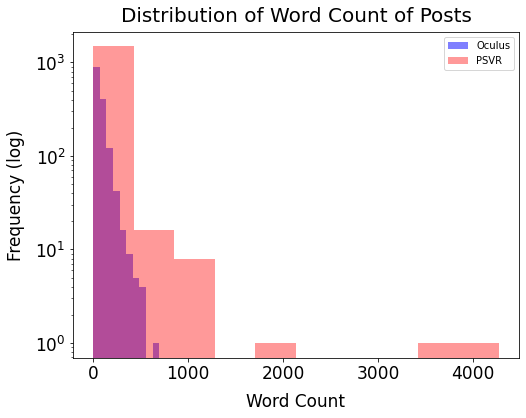

In [40]:
# Distribution of word count logged

plt.figure(figsize = (8,6))


plt.hist(x = oc_word_count, color="blue", label="Oculus", 
             log = True, alpha = 0.5, stacked = True)
plt.hist(x = ps_word_count,color="red", label="PSVR", 
             log = True, alpha = 0.4, stacked = True)

plt.title('Distribution of Word Count of Posts', size = 20, pad = 10)
plt.ylabel(ylabel = 'Frequency (log)', size = 17, labelpad = 10)
plt.xlabel(xlabel = 'Word Count', size = 17, labelpad = 10)
plt.xticks(size = 17)
plt.yticks(size = 17)
plt.legend(); 
plt.savefig('./images/word_count.png');

There's a higher freqency for shorter word counts and smaller frequency for word counts for both data sets. However, 

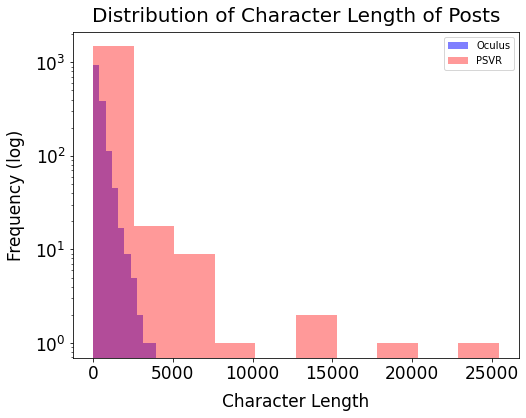

In [41]:
# Distribution of character length logged 

plt.figure(figsize = (8,6))
# ([df1['text'],df2['printed']],
plt.hist(x = oc_char_length, color="blue", label="Oculus", 
             log = True, alpha = 0.5)
plt.hist(x = ps_char_length,color="red", label="PSVR", 
             log = True, alpha = 0.4)

plt.title('Distribution of Character Length of Posts', size = 20, pad = 10)
plt.ylabel(ylabel = 'Frequency (log)', size = 17, labelpad = 10)
plt.xlabel(xlabel = 'Character Length', size = 17, labelpad = 10)
plt.xticks(size = 17)
plt.yticks(size = 17)
plt.legend(); 

plt.savefig('./images/char_len.png')

There is a similiar distribution of character length of posts to word count, with a skew to the right. There are some outliers in PSVR that I will investigate in the next few steps.

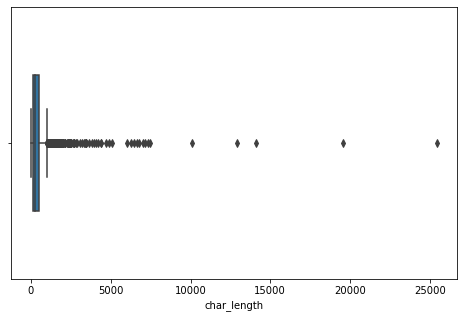

In [42]:
# Boxplot of Character Length
plt.figure(figsize = (8,5))
sns.boxplot(x = df['char_length'], width = 0.5);

In [43]:
# Sorting values to get outlier indices 
df['char_length'].sort_values(ascending = False)[:10]

id
nxjcw3    25438
oi1gbg    19543
ns1y1r    14136
nrzxpy    12894
p1k2e8    10084
o9lhl6     7467
oomyrm     7355
p7gqwb     7172
nrvjqc     7043
pb6q1n     6764
Name: char_length, dtype: int64

Looks like the first outlier is 10,084. Will look at rows in the next few steps.

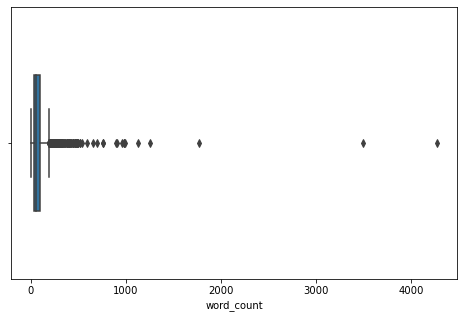

In [44]:
# Boxplot of Word Count
plt.figure(figsize = (8,5))
sns.boxplot(x = df['word_count'], width = 0.5);

In [45]:
# Sorting values to get outlier indices 
df['word_count'].sort_values(ascending = False)[:6]

id
nxjcw3    4271
oi1gbg    3496
p1k2e8    1769
nrvjqc    1255
o6lkfp    1125
nizitr     990
Name: word_count, dtype: int64

Looks like the first outlier is starts after 1255.

In [46]:
# Filtering to see outlier values
outliers = df.loc[(df['word_count'] > 1300) | (df['char_length'] > 10000)]
outliers

,created_utc,num_comments,selftext,subreddit,date,time,char_length,word_count
id,,,,,,,,
p1k2e8,1628578862,14,**tl;dr**\n\nIf you have any interest in musi...,0,2021-08-10,0,10084,1769
oi1gbg,1625995984,57,\n\nYesterday I got worlds 1st Platinum in [...,0,2021-07-11,2,19543,3496
nxjcw3,1623427152,150,So I recently hit this milestone of the 100th ...,0,2021-06-11,8,25438,4271
ns1y1r,1622802665,99,Looks like we have a really big sale for PSVR ...,0,2021-06-04,3,14136,980
nrzxpy,1622794682,38,Looks like we have another HUGE sale for PSVR ...,0,2021-06-04,1,12894,901


All of these outliers are from the PSVR subreddit. I tested removing these and they negatively impacted my model's performance, so will leave them as is.

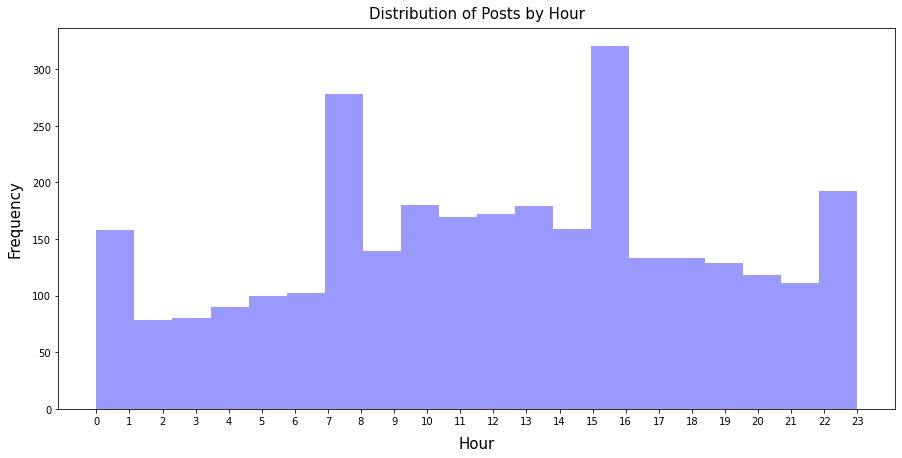

In [47]:
# Distribution of Posts by Hour

plt.figure(figsize = (15,7))
plt.hist(x = df['time'], color="blue", bins = 20, alpha = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.xlabel(xlabel = 'Hour', size = 15, labelpad = 10)
plt.ylabel(ylabel = 'Frequency',size = 15, labelpad = 10)
plt.title('Distribution of Posts by Hour', size = 15, pad = 10);

plt.savefig('./images/dist_hr.png')

Top hours posted: <br>
* 7-8 UTC: Which is 12 AM to 1AM Pacific, 3AM to 4AM Eastern
* 15-16 UTC: Which is 8 AM to 9 AM Pacific, 11 AM to 12 PM Eastern

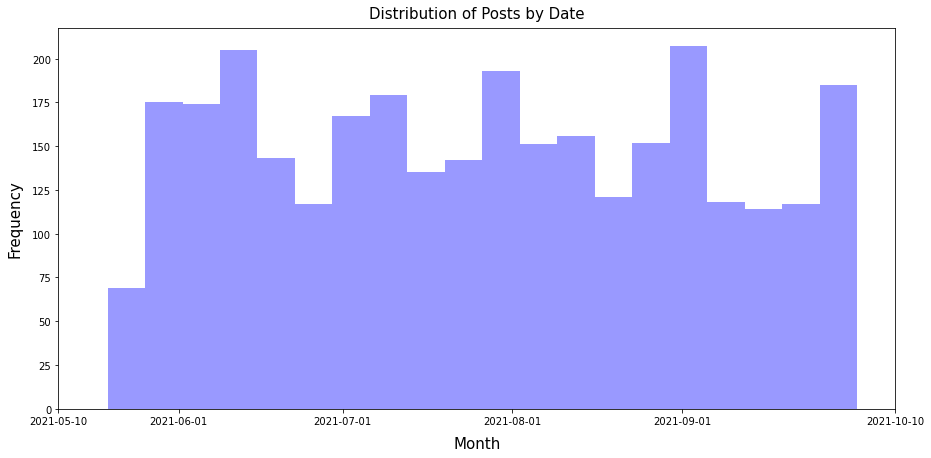

In [48]:
# Distribution of Posts by Date

plt.figure(figsize = (15,7))
plt.hist(x = df['date'], color="blue",bins = 20, alpha = 0.4, orientation = 'vertical')
plt.xlabel(xlabel = 'Month', size = 15, labelpad = 10)
plt.xticks(['2021-05-10','2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-10'])
plt.ylabel(ylabel = 'Frequency',size = 15, labelpad = 10)
plt.title('Distribution of Posts by Date', size = 15, pad = 10);

plt.savefig('./images/dist_date.png')

There's no clear pattern in the distribution of posts by date. From the beginning of September to the end of September/beginning of October appear to be the slowest month over the past 4 months. 

In [49]:
# Summary Statistics
df.describe()

,created_utc,num_comments,subreddit,time,char_length,word_count
count,3.020000e+03,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,1.627360e+09,10.439735,0.500000,12.124503,459.064570,80.523510
std,3.341552e+06,19.548921,0.500083,6.138114,898.285575,136.540439
min,1.621477e+09,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.624368e+09,2.000000,0.000000,8.000000,155.000000,30.000000
50%,1.627399e+09,5.000000,0.500000,12.000000,279.000000,54.000000
75%,1.630296e+09,12.000000,1.000000,17.000000,499.250000,94.000000
max,1.633307e+09,290.000000,1.000000,23.000000,25438.000000,4271.000000


Summary Statistics: <br>
- Number of Comments: The average number of comments per post is 10.40. The min number of comments per post is 0 and the max is 290.
- Character Length: The average character length is 459 while the min is 1 and max is 25438. 
- Word Count: The average word count it 80.5 while the min is 1 and max is 4271. 

In [50]:
df.corr()

,created_utc,num_comments,subreddit,time,char_length,word_count
created_utc,1.000000,-0.018889,0.083257,-0.029737,-0.027237,-0.022492
num_comments,-0.018889,1.000000,-0.209155,-0.111802,0.243238,0.201984
subreddit,0.083257,-0.209155,1.000000,0.066796,-0.035743,-0.010471
time,-0.029737,-0.111802,0.066796,1.000000,-0.067272,-0.054559
char_length,-0.027237,0.243238,-0.035743,-0.067272,1.000000,0.948173
word_count,-0.022492,0.201984,-0.010471,-0.054559,0.948173,1.000000


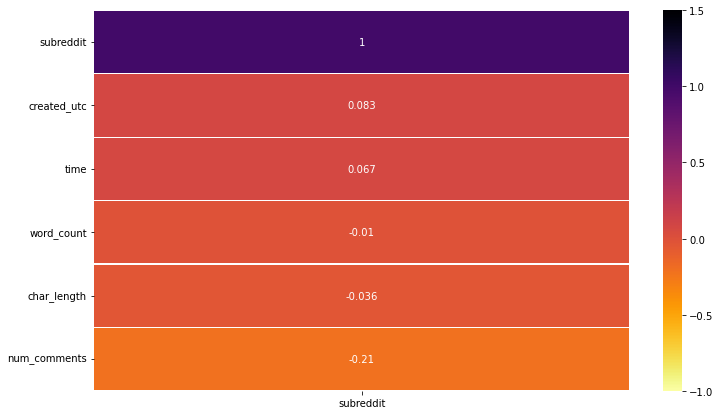

In [54]:
corr = df.corr()
sr_corr = corr[['subreddit']]

plt.figure(figsize = (12,7))
sns.heatmap(data = sr_corr.sort_values(by = 'subreddit', ascending = False),
           annot = True,
           cmap = 'inferno_r',
           linewidths=0.1,
           yticklabels= True,
           xticklabels= True,
           vmin=-1,
           vmax=1.5)
plt.yticks(rotation = 0);

plt.savefig('./images/corr.png')

Correlation: 
- Character Length and Word Count have the strongest correlation at 0.948. 
- Both Word Count and Character Count have a correlation with Number of Comments of less than 0.25.
- Created UTC has the strongest correlation with Subreddit at 0.083. Time has a 0.066 correlation with Subreddit.

### Text Data Analysis

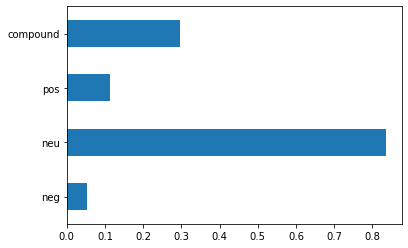

In [55]:
sent = SentimentIntensityAnalyzer()
sentiment = []
for i in df['selftext']:
    sentiment.append(sent.polarity_scores(i))
    
sentimentdf = pd.DataFrame(sentiment).mean()
sentimentdf.plot(kind = 'barh');

After a quick sentiment analysis, it looks like most posts are classified as neutral. This may be interesting to analyze further in a future project, but I will hold off for now. 

## Pre-Processing & Modeling

In [56]:
# Creating df for selftext with same index as df
st = df['selftext']
st_index = df.index

In [57]:
# Setting up CountVectorizer
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(st)
st = cvec.transform(st).toarray()
st_df = pd.DataFrame(st, columns = cvec.get_feature_names(),index = st_index)  # to array or to dense to make df

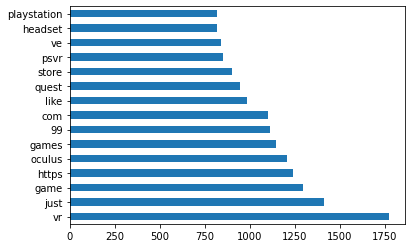

In [58]:
# Top 15 words across both datasets
top_15 = st_df.sum().sort_values(ascending = False).head(15)
top_15.plot(kind = 'barh');

VR is mentioned in over 1750 posts. That's over 57% of the posts. 

In [59]:
# Merging count vectorizer with df
words = pd.merge(left = df, right = st_df, how = 'outer', left_index = True, right_index = True)

In [60]:
# Filtering for Oculus Strings
oc_words = words.loc[words['subreddit_x'] == 1, :]
oc_words.drop(columns = ['selftext','created_utc', 'char_length', 'word_count', 'time_x', 'num_comments', 'subreddit_x'], inplace = True)

/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
# Top 5 Oculus Strings
oc_words.sum().sort_values(ascending = False)[:5]

oculus     1174
quest       901
just        704
vr          595
headset     509
dtype: int64

In [62]:
# Pulling the top 125 oculus strings and creating a new list
oc_top_words = oc_words.sum().sort_values(ascending = False)[:125]
oc_top_words = pd.DataFrame(oc_top_words)
oc_top_words = oc_top_words.index
octw  = []
for i,v in enumerate(oc_top_words):
    octw.append(v)

In [63]:
# Filtering for PS strings
ps_words = words.loc[words['subreddit_x'] == 0, :]
ps_words.drop(columns = ['selftext','created_utc', 'char_length', 'word_count', 'time_x', 'num_comments', 'subreddit_x'], inplace = True)

/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [64]:
# Top 5 PS Strings
ps_words.sum().sort_values(ascending = False)[:5]

vr       1177
99       1106
https     989
com       925
game      897
dtype: int64

While the Oculus top strings included the Oculus brand name as well as the Oculus headset, Quest, the PSVR top strings didn't include the brand name or anything that would really identify PSVR.

In [65]:
# Pulling the top 125 ps strings and creating a new list
ps_top_words = ps_words.sum().sort_values(ascending = False)[:125]
ps_top_words = pd.DataFrame(ps_top_words)
ps_top_words = ps_top_words.index
pstw  = []
for i,v in enumerate(ps_top_words):
    pstw.append(v)

In [66]:
# Creating a common strings set with set intersection of ps and oculus strings
pstw_set = set(pstw)
octw_set = set(octw)
common_words = pstw_set.intersection(octw)
commons_words = set(common_words)
print(common_words)

{'good', 'saber', 'work', 'set', 'know', 'headset', 'amp', 'ago', 'tried', 'just', 'www', 'recently', 'thanks', 'used', 'need', 'com', 'does', 've', 'using', 'vr', 'sure', 'working', 'game', 'issue', 'controller', 'works', 'getting', 'different', 'got', 'screen', 'cable', 'fine', 'experience', 'https', 'think', 'things', 'use', 'fix', 'right', 'tracking', 'make', 'today', 'way', 'long', 'new', 'like', 'wondering', 'store', 'try', 'didn', 'playing', 'help', 'really', 'bought', 'don', 'problem', 'play', 'beat', 'doesn', 'having', 'going', 'games', 'time_y', 'looking', 'turn', 'did', 'trying', 'people', 'buy', 'want', 'better', 'controllers', 'let', 'x200b', 'thing', 'update'}


In [67]:
# Creating english stopword set
english = stopwords.words('english')
english = set(english)

In [68]:
# Combining english set and common words with union
vr_english =  english.union(common_words)

In [69]:
print(vr_english)

{'work', 'he', 'during', 'know', 'amp', "weren't", 'ma', 'being', 'will', 'if', 'himself', 'ago', 'yourself', 'after', 'just', 'www', 'your', 'be', "it's", 'her', 'can', "needn't", 'need', 'now', 'not', 'sure', 'vr', 'working', 'game', 'to', 'mustn', 'as', 'issue', 'mightn', 'different', 'its', 'these', 'couldn', 'with', 'nor', 'use', 'further', 'tracking', 'both', 'than', 'today', 'whom', "isn't", 'like', 'store', 'my', 'at', 'above', 'from', 'his', 'bought', 'it', 'don', 'play', 'when', 'him', 'doesn', 'looking', 'buy', 'am', 'better', "doesn't", 'here', 'of', 'update', 'an', 'and', 'good', "you've", 'where', 'again', 'set', 'a', "mightn't", 'headset', 'y', 'o', "hadn't", 'against', "you'll", 'which', 'there', 'isn', 'but', 'any', 'do', 'works', 'me', 'wasn', 'https', 'them', 'very', 'themselves', 'should', 'aren', 'down', 'who', 'on', "won't", 'way', 'new', 'before', 'out', 'between', 'help', 'really', 'she', 'hadn', "you'd", 't', 'beat', 'are', 'time_y', 'you', 'did', 'trying', 'ou

I believe with the data I've collected, cleaned, and analyzed I should be able to build a model that predicts what subreddit submissions come from. 

In [70]:
# Setting X & Y
X = df['selftext']
y = df['subreddit']

### Baseline Accuracy

In [71]:
# Train test split - Stratifying because this is classification
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

In [72]:
# Accuracy score
y_train.value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

The Baseline model has 50% accuracy. 

### Multinomial Naiive Bayes

#### MNB Using TF-IDF

In [73]:
count = 0 
nb_tvec_params = {}

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

nb_tvec_params = nb_tvec_params
count = count

nb_tvec_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [5000,6000],
    'tvec__stop_words': [vr_english,'english'],
    'tvec__max_df':[0.25,0.3,0.4],
    'tvec__ngram_range': [(1,1),(1,2)],
    'tvec__min_df': [1,2,3] 
}

gs_nbt = GridSearchCV(nb_tvec_pipe, param_grid = pipe_params, cv = 3, verbose = 1, n_jobs = 3)
gs_nbt.fit(X_train, y_train)

count += 1

gs_nbt.best_params_['score'] = gs_nbt.best_score_ 
gs_nbt.best_params_['train_score'] = gs_nbt.score(X_train, y_train)
gs_nbt.best_params_['test_score'] = gs_nbt.score(X_test, y_test)

nb_tvec_params[f'nbt_{count}'] = gs_nbt.best_params_   

nb_tvec_df = pd.DataFrame.from_dict(nb_tvec_params, orient = 'index')

nb_tvec_df

Fitting 3 folds for each of 72 candidates, totalling 216 fits


,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score,train_score,test_score
nbt_1,0.25,5000,2,"(1, 2)","{work, he, during, know, amp, weren't, ma, bei...",0.869439,0.950331,0.88521


Tested multiple parameters. This model did better with a higher max features and an ngram range of (1,2). This is performing pretty well, but a bit overfit, so I will want to test CountVectorizer. 

#### MNB Using CountVectorizer

In [75]:
count = 0 
nb_cvec_params = {}

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

nb_cvec_params = nb_cvec_params
count = count

nb_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features':[1000,2000,3000], 
    'cvec__max_df':[0.2,0.3,0.4],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[vr_english, 'english']
}

gs_nbc = GridSearchCV(nb_cvec_pipe, param_grid = pipe_params, cv = 3, verbose = 1, n_jobs = 3)
gs_nbc.fit(X_train, y_train)

count += 1

gs_nbc.best_params_['score'] = gs_nbc.best_score_ 
gs_nbc.best_params_['train_score'] = gs_nbc.score(X_train, y_train)
gs_nbc.best_params_['test_score'] = gs_nbc.score(X_test, y_test)

nb_cvec_params[f'nbc_{count}'] = gs_nbc.best_params_

nb_cvec_df = pd.DataFrame.from_dict(nb_cvec_params, orient = 'index')

nb_cvec_df

Fitting 3 folds for each of 36 candidates, totalling 108 fits


,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,score,train_score,test_score
nbc_1,0.3,3000,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",0.848148,0.900662,0.862031


This model didn't test as well as above. It is less overfit though. 

In [77]:
# Dataframe code inspired by lesson 6.03

#### MNB Using CV & TF-IDF

In [78]:
count = 0 
nb_params = {}

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

nb_params = nb_params
count = count

nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features':[1000,2000,3000,5000], 
    'cvec__max_df':[0.2,0.3,0.4],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[vr_english, 'english'],
    'tfidf__use_idf':[True,False]
    
}

gs_nb = GridSearchCV(nb_pipe, param_grid = pipe_params, cv = 3, verbose = 1, n_jobs = 3)
gs_nb.fit(X_train, y_train)

count += 1

gs_nb.best_params_['score'] = gs_nb.best_score_ 
gs_nb.best_params_['train_score'] = gs_nb.score(X_train, y_train)
gs_nb.best_params_['test_score'] = gs_nb.score(X_test, y_test)

nb_params[f'nbt_{count}'] = gs_nb.best_params_   

nb_df = pd.DataFrame.from_dict(nb_params, orient = 'index')

nb_df

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,tfidf__use_idf,score,train_score,test_score
nbt_1,0.3,5000,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",False,0.880793,0.950331,0.90287


This model is performing the best out of the other two MNB models. It did not use idf like I had expected it to, but it has the highest train and test score of the three. Going to plot a confusion matrix and look at some other metrics. 

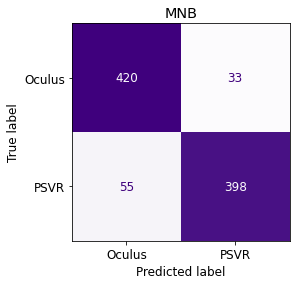

In [80]:
preds_nb = gs_nb.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_nb).ravel()
plt.rcParams.update({'font.size': 12})     #
plot_confusion_matrix(gs_nb, X_test, y_test, cmap = 'Purples',colorbar = False, display_labels = ['Oculus','PSVR']);
plt.title('MNB');
plt.savefig('./images/mnb.png')
# params update font size adapted from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

In [81]:
print(f'Precision Rate: {precision_score(y_test, preds_nb)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_nb)}')
print(f'Misclassification: {1 - (gs_nb.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_nb)}')

Precision Rate: 0.9234338747099768
Specificity Rate: 0.9271523178807947
Recall Rate: 0.8785871964679912
Misclassification: 0.09713024282560712
F1 Score: 0.9004524886877828


These rates looks pretty good, though Recall could be a little higher. Need to look at other models before evaluating

### Random Forest

#### RF Using IDF

In [82]:
count = 0 
rft_params = {}

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

rft_params = rft_params
count = count

rft_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [80],
    'rf__max_depth': [4],
    'rf__ccp_alpha': [0.0001],
    'rf__bootstrap': [True],
    'rf__max_features': ['sqrt'],
    'tvec__stop_words': [vr_english],
    'tvec__ngram_range': [(1,1)],
    'tvec__min_df':[11],
    'tvec__max_features': [1000]
}

gs_rft = GridSearchCV(rft_pipe, param_grid = params, cv = 3, n_jobs = 2)

gs_rft.fit(X_train, y_train)

count += 1

gs_rft.best_params_['score'] = gs_rft.best_score_ 
gs_rft.best_params_['train_score'] = gs_rft.score(X_train, y_train)
gs_rft.best_params_['test_score'] = gs_rft.score(X_test, y_test)

rft_params[f'rft_{count}'] = gs_rft.best_params_

rft_df = pd.DataFrame.from_dict(rft_params, orient = 'index')

rft_df

,rf__bootstrap,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__n_estimators,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score,train_score,test_score
rft_1,True,0.0001,4,sqrt,80,1000,11,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",0.867076,0.873226,0.855408


RF with IDF not performing as well as MNB. Will try RF with CountVectorizer next next. 

#### RF Using CountVectorizer

In [84]:
count = 0 
rfc_params = {}

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

rfc_params = rfc_params
count = count

rfc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [70,75,80],
    'rf__max_depth': [2,3,4],
    'rf__ccp_alpha': [0.001,0.0001],
    'rf__bootstrap': [True],
    'rf__max_features': ['sqrt','log2'],
    'cvec__max_features':[1000,2000], 
    'cvec__max_df':[0.2,0.7],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[vr_english, 'english']

}

gs_rfc = GridSearchCV(rfc_pipe, param_grid = params, cv = 3, n_jobs = 2)

gs_rfc.fit(X_train, y_train)

count += 1

gs_rfc.best_params_['score'] = gs_rfc.best_score_ 
gs_rfc.best_params_['train_score'] = gs_rfc.score(X_train, y_train)
gs_rfc.best_params_['test_score'] = gs_rfc.score(X_test, y_test)

rfc_params[f'rfc_{count}'] = gs_rfc.best_params_


rfc_df = pd.DataFrame.from_dict(rfc_params, orient = 'index')

rfc_df

/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,rf__bootstrap,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__n_estimators,score,train_score,test_score
rfc_1,0.7,1000,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",True,0.001,4,sqrt,75,0.873228,0.866131,0.856512


This RF model is performing slightly better than the previous RF model. It has a lower score than MNB, however, it isn't as overfit as the MNB models were. Going to plot a confusion matrix and look at classification metrics.

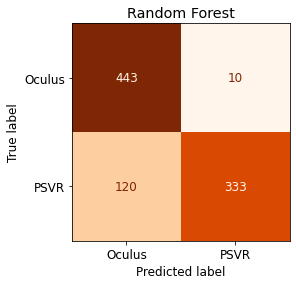

In [86]:
preds_rfc = gs_rfc.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_rfc).ravel()

plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(gs_rfc, X_test, y_test, cmap = 'Oranges', colorbar = False, display_labels = ['Oculus','PSVR']);
plt.title('Random Forest')
plt.savefig('./images/rf.png')

Lower amount of false positives than the MNB model(33 FP) but double the amount of false negatives. 

In [87]:
print(f'Precision Rate: {precision_score(y_test, preds_rfc)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_rfc)}')
print(f'Misclassification: {1 - (gs_rfc.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_rfc)}')

Precision Rate: 0.9708454810495627
Specificity Rate: 0.977924944812362
Recall Rate: 0.7350993377483444
Misclassification: 0.14348785871964675
F1 Score: 0.8366834170854273


In [88]:
f1_score(y_test, preds_rfc)

0.8366834170854273

Recall rate is performing worse than MNB and Misclassification is higher. Precision and Specificity are performing better in this model. 

### Support Vector Machines

#### SVC Using Count Vectorizer

In [89]:
count = 0 
svc_params = {}

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

svc_params = svc_params
count = count

svc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

p_grid = {
    'svc__C' : np.linspace(1, 20, 20),
    'svc__kernel' : ['poly'],
    'svc__degree' : [1, 2],
    'cvec__max_features': [1000],
    'cvec__stop_words':[vr_english, 'english'],
    'cvec__max_df':[0.2,0.7]
}


gs_svc = GridSearchCV(svc_pipe, param_grid = p_grid, cv = 3, verbose = 1, n_jobs = 2)
gs_svc.fit(X_train, y_train)

count += 1

gs_svc.best_params_['score'] = gs_svc.best_score_ 
gs_svc.best_params_['train_score'] = gs_svc.score(X_train, y_train)
gs_svc.best_params_['test_score'] = gs_svc.score(X_test, y_test)


svc_params[f'svcc_{count}'] = gs_svc.best_params_   

svc_df = pd.DataFrame.from_dict(svc_params, orient = 'index')

svc_df

Fitting 3 folds for each of 160 candidates, totalling 480 fits


/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,cvec__max_df,cvec__max_features,cvec__stop_words,svc__C,svc__degree,svc__kernel,score,train_score,test_score
svcc_1,0.7,1000,english,19.0,1,poly,0.86329,0.94087,0.857616


This model is very overfit and isn't performing well. Going to try using IDF.

#### SVC Using IDF

In [91]:
count = 0 
svct_params = {}

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

svct_params = svc_params
count = count

svct_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

p_grid = {
    'svc__C' : np.linspace(1, 20, 20),
    'svc__kernel' : ['poly'],
    'svc__degree' : [2],
    'tvec__stop_words': [vr_english,'english'],
    'tvec__ngram_range': [(1,1)],
    'tvec__max_features':[6000]
}

gs_svct = GridSearchCV(svct_pipe, param_grid = p_grid, cv = 3, verbose = 1, n_jobs = 1)
gs_svct.fit(X_train, y_train)

count += 1

gs_svct.best_params_['score'] = gs_svct.best_score_ 
gs_svct.best_params_['train_score'] = gs_svct.score(X_train, y_train)
gs_svct.best_params_['test_score'] = gs_svct.score(X_test, y_test)

svct_params[f'svct_{count}'] = gs_svct.best_params_   

svct_df = pd.DataFrame.from_dict(svct_params, orient = 'index')

svct_df

Fitting 3 folds for each of 40 candidates, totalling 120 fits


,cvec__max_df,cvec__max_features,cvec__stop_words,svc__C,svc__degree,svc__kernel,score,train_score,test_score,tvec__max_features,tvec__ngram_range,tvec__stop_words
svcc_1,0.7,1000.0,english,19.0,1,poly,0.863290,0.940870,0.857616,NaN,NaN,NaN
svct_1,NaN,NaN,NaN,2.0,2,poly,0.875119,0.997162,0.880795,6000.0,"(1, 1)",english


Setting the SVC degree to 2 improved the score, but it's still highly overfit. Going to try using CV & IDF.

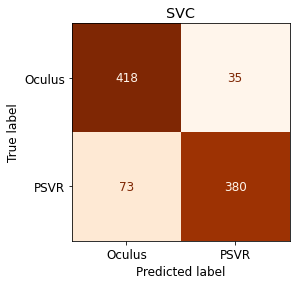

In [93]:
preds_svct = gs_svct.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_svct).ravel()

plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(gs_svct, X_test, y_test, cmap = 'Oranges', colorbar = False, display_labels = ['Oculus','PSVR']);
plt.title('SVC')
plt.savefig('./images/svc.png')

In [94]:
print(f'Precision Rate: {precision_score(y_test, preds_svct)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_svct)}')
print(f'Misclassification: {1 - (gs_svct.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_svct)}')

Precision Rate: 0.9156626506024096
Specificity Rate: 0.9227373068432672
Recall Rate: 0.8388520971302428
Misclassification: 0.11920529801324509
F1 Score: 0.8755760368663594


#### SVC Using CountVectorizer & IDF

In [95]:
count = 0 
svctc_params = {}

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

svctc_params = svctc_params
count = count

svctc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC())
])

pipe_params = {
    'svc__C' : np.linspace(1, 20, 20),
    'svc__kernel' : ['poly'],
    'svc__degree' : [2],
    'cvec__max_features':[3000], 
    'cvec__max_df':[0.2],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[vr_english],
    'tfidf__use_idf':[True,False]
    
}

gs_svctc = GridSearchCV(svctc_pipe, param_grid = pipe_params, cv = 3, verbose = 1, n_jobs = 1)
gs_svctc.fit(X_train, y_train)

count += 1

gs_svctc.best_params_['score'] = gs_svctc.best_score_ 
gs_svctc.best_params_['train_score'] = gs_svctc.score(X_train, y_train)
gs_svctc.best_params_['test_score'] = gs_svctc.score(X_test, y_test)

svctc_params[f'svct_{count}'] = gs_svctc.best_params_   

svctc_df = pd.DataFrame.from_dict(svctc_params, orient = 'index')

svctc_df

Fitting 3 folds for each of 80 candidates, totalling 240 fits


,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,svc__C,svc__degree,svc__kernel,tfidf__use_idf,score,train_score,test_score
svct_1,0.2,3000,"(1, 2)","{work, he, during, know, amp, weren't, ma, bei...",19.0,2,poly,False,0.857141,0.996216,0.856512


This model is highly overfit. Going to move on to Logistic Regression.

### Logistic Regression

#### Logistic Regression Using CountVectorizer

In [97]:
count = 0 
lrc_params = {}

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

lrc_params = lrc_params  
count = count

lrc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

params = {
    'lr__l1_ratio': [0.1,0.9],
    'lr__penalty':['elasticnet'],
    'lr__solver': ['saga'],
    'cvec__max_features':[2000,3000,4000],
    'cvec__stop_words':[vr_english,'english'],
    'cvec__max_df':[0.5],
    'cvec__min_df':[3,5],
    'cvec__ngram_range':[(1,1),(1,2)]
    
}

gs_lrc = GridSearchCV(lrc_pipe, param_grid=params, cv = 3, verbose = 1, n_jobs = 5)
gs_lrc.fit(X_train, y_train)

count += 1

gs_lrc.best_params_['score'] = gs_lrc.best_score_ 
gs_lrc.best_params_['train_score'] = gs_lrc.score(X_train, y_train)
gs_lrc.best_params_['test_score'] = gs_lrc.score(X_test, y_test)

lrc_params[f'lrc_{count}'] = gs_lrc.best_params_   

lrc_df = pd.DataFrame.from_dict(lrc_params, orient = 'index')

lrc_df

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Users/jenz/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,lr__l1_ratio,lr__penalty,lr__solver,score,train_score,test_score
lrc_1,0.5,4000,3,"(1, 2)","{work, he, during, know, amp, weren't, ma, bei...",0.9,elasticnet,saga,0.881263,0.899243,0.883002


This model looks pretty good. While it's not performing the highest on the test score, It appears to be the least overfit. Going to plot a confusion matrix and look at classification metrics.

#### Logistic Regression Using IDF

In [99]:
count = 0
lrt_params = {}

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

lrt_params = lrt_params  
count = count

lrt_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params = {
    'lr__l1_ratio': [0.7,0.9],
    'lr__penalty':['elasticnet'],
    'lr__solver': ['saga'],
    'tvec__max_features': [1000],
    'tvec__stop_words': [vr_english],
    'tvec__ngram_range': [(1,1),(1,2)]
    
}

gs_lrt = GridSearchCV(lrt_pipe, param_grid=params, cv = 3, verbose = 1, n_jobs = 2)
gs_lrt.fit(X_train, y_train)

count += 1

gs_lrt.best_params_['score'] = gs_lrt.best_score_ 
gs_lrt.best_params_['train_score'] = gs_lrt.score(X_train, y_train)
gs_lrt.best_params_['test_score'] = gs_lrt.score(X_test, y_test)

lrt_params[f'lrt_{count}'] = gs_lrt.best_params_   

lrt_df = pd.DataFrame.from_dict(lrt_params, orient = 'index')

lrt_df

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,lr__l1_ratio,lr__penalty,lr__solver,tvec__max_features,tvec__ngram_range,tvec__stop_words,score,train_score,test_score
lrt_1,0.7,elasticnet,saga,1000,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",0.871336,0.917692,0.883002


This is performing slightly better than the previous Logistic Regression model. Going to try CV & IDF next.

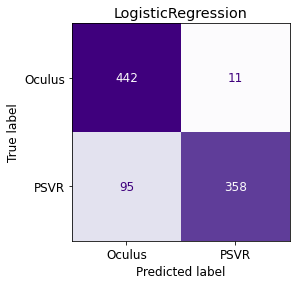

In [101]:
preds_lrc = gs_lrc.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_lrc).ravel()
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(gs_lrt, X_test, y_test, cmap = 'Purples', colorbar = False, display_labels = ['Oculus','PSVR']);
plt.title('LogisticRegression');
plt.savefig('./images/lr.png')

In [102]:
print(f'Precision Rate: {precision_score(y_test, preds_lrc)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_lrc)}')
print(f'Misclassification: {1 - (gs_lrc.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_lrc)}')

Precision Rate: 0.9180722891566265
Specificity Rate: 0.9249448123620309
Recall Rate: 0.8410596026490066
Misclassification: 0.11699779249448128
F1 Score: 0.8778801843317972


Ok scores. Better with MNB model.

#### Logistic Regression Using CountVectorizer & IDF

In [103]:
count = 0
lr_params = {}

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .30, stratify = y, random_state = 321)

lr_params = lr_params
count = count

lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr',LogisticRegression())
])

pipe_params = {
    'lr__l1_ratio': [0.7],
    'lr__penalty':['elasticnet','l1'],
    'lr__solver': ['saga'],
    'cvec__max_features':[1000,1500,2000], 
    'cvec__max_df':[0.3,0.4],
    'cvec__ngram_range':[(1,1),(1,2)],
    'cvec__stop_words':[vr_english],
    'tfidf__use_idf':[True,False],
    'tfidf__sublinear_tf':[True,False],
    
}

gs_lr = GridSearchCV(lr_pipe, param_grid = pipe_params, cv = 3, verbose = 1, n_jobs = 3)
gs_lr.fit(X_train, y_train)

count += 1

gs_lr.best_params_['score'] = gs_lr.best_score_ 
gs_lr.best_params_['train_score'] = gs_lr.score(X_train, y_train)
gs_lr.best_params_['test_score'] = gs_lr.score(X_test, y_test)

lr_params[f'lr_{count}'] = gs_lr.best_params_   

lr_df = pd.DataFrame.from_dict(lr_params, orient = 'index')

lr_df

Fitting 3 folds for each of 96 candidates, totalling 288 fits


,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,lr__l1_ratio,lr__penalty,lr__solver,tfidf__sublinear_tf,tfidf__use_idf,score,train_score,test_score
lr_1,0.4,1000,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",0.7,elasticnet,saga,False,True,0.871809,0.917219,0.883002


This has the same performance as the model above. 

### Evaluation

In [105]:
master = pd.concat([nb_tvec_df, nb_cvec_df, nb_df, rft_df, rfc_df, svc_df, svct_df, svctc_df, lrc_df, lrt_df, lr_df], join = 'outer' )
master.sort_values(by = 'test_score', ascending = False)

,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,tvec__stop_words,score,train_score,test_score,cvec__max_df,cvec__max_features,cvec__ngram_range,cvec__stop_words,tfidf__use_idf,rf__bootstrap,rf__ccp_alpha,rf__max_depth,rf__max_features,rf__n_estimators,svc__C,svc__degree,svc__kernel,cvec__min_df,lr__l1_ratio,lr__penalty,lr__solver,tfidf__sublinear_tf
nbt_1,NaN,NaN,NaN,NaN,NaN,0.880793,0.950331,0.902870,0.3,5000.0,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nbt_1,0.25,5000.0,2.0,"(1, 2)","{work, he, during, know, amp, weren't, ma, bei...",0.869439,0.950331,0.885210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lrc_1,NaN,NaN,NaN,NaN,NaN,0.881263,0.899243,0.883002,0.5,4000.0,"(1, 2)","{work, he, during, know, amp, weren't, ma, bei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.9,elasticnet,saga,NaN
lrt_1,NaN,1000.0,NaN,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",0.871336,0.917692,0.883002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,elasticnet,saga,NaN
lr_1,NaN,NaN,NaN,NaN,NaN,0.871809,0.917219,0.883002,0.4,1000.0,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7,elasticnet,saga,False
svct_1,NaN,6000.0,NaN,"(1, 1)",english,0.875119,0.997162,0.880795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,poly,NaN,NaN,NaN,NaN,NaN
nbc_1,NaN,NaN,NaN,NaN,NaN,0.848148,0.900662,0.862031,0.3,3000.0,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svcc_1,NaN,NaN,NaN,NaN,NaN,0.863290,0.940870,0.857616,0.7,1000.0,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,19.0,1.0,poly,NaN,NaN,NaN,NaN,NaN
svcc_1,NaN,NaN,NaN,NaN,NaN,0.863290,0.940870,0.857616,0.7,1000.0,NaN,english,NaN,NaN,NaN,NaN,NaN,NaN,19.0,1.0,poly,NaN,NaN,NaN,NaN,NaN
rfc_1,NaN,NaN,NaN,NaN,NaN,0.873228,0.866131,0.856512,0.7,1000.0,"(1, 1)","{work, he, during, know, amp, weren't, ma, bei...",NaN,True,0.0010,4.0,sqrt,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
master.to_csv('./data/master_df.csv')

#### Classification Metrics - In Addition to Accuracy

In [107]:
# MNB
print(f'Precision Rate: {precision_score(y_test, preds_nb)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_nb)}')
print(f'Misclassification: {1 - (gs_nb.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_nb)}')

Precision Rate: 0.9234338747099768
Specificity Rate: 0.9249448123620309
Recall Rate: 0.8785871964679912
Misclassification: 0.09713024282560712
F1 Score: 0.9004524886877828


In [108]:
# RF
print(f'Precision Rate: {precision_score(y_test, preds_rfc)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_rfc)}')
print(f'Misclassification: {1 - (gs_rfc.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_rfc)}')

Precision Rate: 0.9708454810495627
Specificity Rate: 0.9249448123620309
Recall Rate: 0.7350993377483444
Misclassification: 0.14348785871964675
F1 Score: 0.8366834170854273


In [109]:
# LR
print(f'Precision Rate: {precision_score(y_test, preds_lrc)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_lrc)}')
print(f'Misclassification: {1 - (gs_lrc.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_lrc)}')

Precision Rate: 0.9180722891566265
Specificity Rate: 0.9249448123620309
Recall Rate: 0.8410596026490066
Misclassification: 0.11699779249448128
F1 Score: 0.8778801843317972


In [110]:
# SVC
print(f'Precision Rate: {precision_score(y_test, preds_svct)}')
print(f'Specificity Rate: {(tn / (tn + fp))}')
print(f'Recall Rate: {recall_score(y_test, preds_svct)}')
print(f'Misclassification: {1 - (gs_svct.score(X_test, y_test))}')
print(f'F1 Score: {f1_score(y_test,preds_svct)}')

Precision Rate: 0.9156626506024096
Specificity Rate: 0.9249448123620309
Recall Rate: 0.8388520971302428
Misclassification: 0.11920529801324509
F1 Score: 0.8755760368663594


### Evaluation

Since we were not biased against False Negatives compared to False Positives, the F1 score was the score that was the final determinant to which model to go with. The MNB model had the best accuracy score, Recall Rate, Misclassification Rate, and F1 Score compared to the other models tested.

MNB Metric Evaluation: 
- Accuracy: 0.902
    * This is the rate of submissions I correctly predicted
- Misclassification: 0.097
    * This is the rate of submissions I incorrectly predicted
- Specificity: 0.924
    * Among all of the submissions, I predicted the correct subreddit at this rate. 
- Recall: 0.878
    * Among the submissions that belong to the subreddit, Oculus, I predicted them correctly at this rate.
- Precision: 0.097
    * Among the submissions that belong to the subreddit, PSVR, I predicted them correctly at this rate.
- F1 Score: 0.900
    * Since we are not biased to PSVR or Oculus, this is the mean score of precision and recall.

### Conclusions and Recommendations 

#### Conclusions
After fitting a plethora of models, it turns out my best model was my first model, Multinomial Naive Bayes. With an accuracy rate of 90.2% , this model performed 40.2% better than the baseline model. 

A Multinomial Naive Bayes model with Count Vectorization and the following parameters should be used for predicting whether a submission comes from the r/oculus or r/PSVR subreddit: 
- max_df: 0.3
- max_features: 5000
- ngram_range: (1,1)
- stop_words: english + 150 of the most common words

However, this model still needs some improvement as about 9% of the submissions were being misclassified.


#### Recommendations

While this is a great model, I think it could use some improvement before deploying it across the video game prediction algorithms. 
<br>
<br>
My recommendations include: 
- Since the Oculus subreddit was misclassified at a higher rate than the PSVR subreddit, I recommend optimizing for recall.
- Focus on Feature Engineering
    * Try other text processing methods
        - Lemmatization, Stemming, Wor2vec
    * Try adding additional features like title and/or UTC
- Test other models and parameters
- Test on different types of video game subreddits


After a little more fine-tuning, I believe this will be a successful model to be used across the division.
